In [1]:
# from IPython.display import display, HTML
# from IPython.display import display, HTML
# from ipywidgets import interact, widgets
# %matplotlib notebook

# %matplotlib ipympl
%matplotlib widget

import scipy.constants as sc
from scipy.optimize import fsolve

import numpy as np
import cmath
import matplotlib.pyplot as plt
import scipy.constants as sc
plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r"\usepackage{amsmath} \boldmath"
})
import os
import h5py


# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)


print(os.getpid())
%cd ../../

import pylib.mix as mix

15400
C:\Users\novikau1\Documents\work\codes\QuCF\scripts-py


In [16]:
# ---------------------------------------------------------------------------------------------------
# --- Consider the Lotka-Volterra prey-predator model:
# --- d x / d t =  wx*x - gx*x*y = Fx ---
# --- d y / d t = -wy*y + gy*x*y = Fy ---
# ---------------------------------------------------------------------------------------------------
mix.reload_module(mix)

t_end = 20
Nt = 5000
t_array = np.linspace(0, t_end, Nt)
dt = np.diff(t_array)[0]

x0, y0 = 0.4, 0.8
wx, wy, gx, gy = 1, 1.2, 2, 2.1

Fx = lambda x, y:  wx*x - gx*x*y
Fy = lambda x, y: -wy*y + gy*x*y

In [17]:
# ---------------------------------------------------------------------------------------------------
# --- Direct solver:
# ---------------------------------------------------------------------------------------------------
mix.reload_module(mix)

class DirectSolver__:
    xt_ = None
    yt_ = None
    Nt_ = None
    dt_ = None
    Fx_ = None
    Fy_ = None
    t_ = None
    def __init__(self, x0, y0, Fx, Fy, t):
        self.t_ = np.array(t)
        self.Nt_ = len(self.t_)
        self.dt_ = np.diff(self.t_)[0]
        self.Fx_ = Fx
        self.Fy_ = Fy
        self.xt_ = np.zeros(self.Nt_, dtype=float)
        self.yt_ = np.zeros(self.Nt_, dtype=float)
        self.xt_[0] = x0
        self.yt_[0] = y0
        return

    def solve(self):
        for it in range(Nt-1):
            self.xt_[it+1] = self.xt_[it] + self.dt_ * self.Fx_(self.xt_[it], self.yt_[it])
            self.yt_[it+1] = self.yt_[it] + self.dt_ * self.Fy_(self.xt_[it], self.yt_[it])
        return
        

ds = DirectSolver__(x0, y0, Fx, Fy, t_array)    
ds.solve()

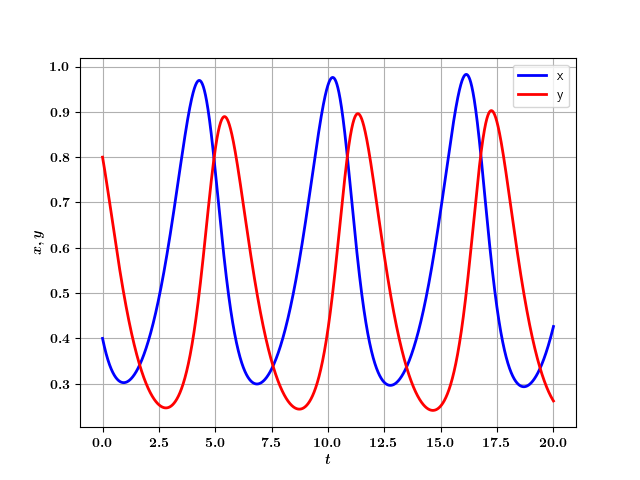

In [18]:
# --- Plot results from the direct solver ---
plt.close()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ds.t_, ds.xt_, color='b', linewidth = 2, linestyle='-', label="x")
ax.plot(ds.t_, ds.yt_, color='r', linewidth = 2, linestyle='-', label="y")
plt.xlabel('$t$')
plt.ylabel("$x,y$")
ax.legend()
plt.grid(True)
plt.show()

In [21]:
# ---------------------------------------------------------------------------------------------------
# --- KvN solver:
# ---------------------------------------------------------------------------------------------------
class KvN__:
    psi_ = None
    n_ = None
    N_ = None # the number of points to describe a single variable;
    t_ = None
    delta_x_, delta_y_ = None, None
    x0_, y0_ = None, None
    x_, y_ = None, None
    dx_, dy_ = None, None
    wx_, wy_, gx_, gy_ = None, None, None, None

    def __init__(self, x0, y0, t, wx, wy, gx, gy):
        # time grid
        self.t_ = np.array(t)
        self.Nt_ = len(self.t_)
        self.dt_ = np.diff(self.t_)[0]
    
        # grids for the variables:
        self.n_ = 10
        self.N_ = 1 << self.n_
        self.x_ = np.linspace(-2, 2, self.N_)
        self.y_ = np.linspace(-2, 2, self.N_)
        self.dx_ = np.diff(self.x_)[0]
        self.dy_ = np.diff(self.y_)[0]
    
        # state vector:
        self.psi_ = np.zeros((Nt, 2 * self.N_)) # we have two variables
    
        # Initial state parameters:
        self.delta_x_ = 0.1
        self.delta_y_ = 0.05
        self.x0_ = x0
        self.y0_ = y0
        
        coef_gauss_x = 1./(np.sqrt(2.*np.pi) * self.delta_x_)
        for ii in range(self.N_):
            self.psi_[0,ii]           = np.exp(-(self.x_[ii] - self.x0_)**2/(2.*self.delta_x_**2))
            self.psi_[0,ii + self.N_] = np.exp(-(self.y_[ii] - self.y0_)**2/(2.*self.delta_y_**2))

    def get_psi_x(self, id_t):
        return self.psi_[id_t, 0:self.N_]

    def get_psi_y(self, id_t):
        return self.psi_[id_t, self.N_:(2*self.N_)]

    def solve(self):
        # we use Dirichlet boundary conditions:
        
        for it in range(Nt-1):
            for ix in range(1,self.N_-1):
                x1 = self.x_[ix]
                y1 = self.y_[ix]
                
                coef_x_2h = ()/self.dx_
                coef_y_2h = y1**2/self.dy_

                
                self.psi_[it+1, ix] = - 
                
                iy = ix + self.N_
                self.psi_[it+1, iy] =


        return
    
# -----------------------------------
kvn = KvN__(x0, y0, t_array, wx, wy, gx, gy)

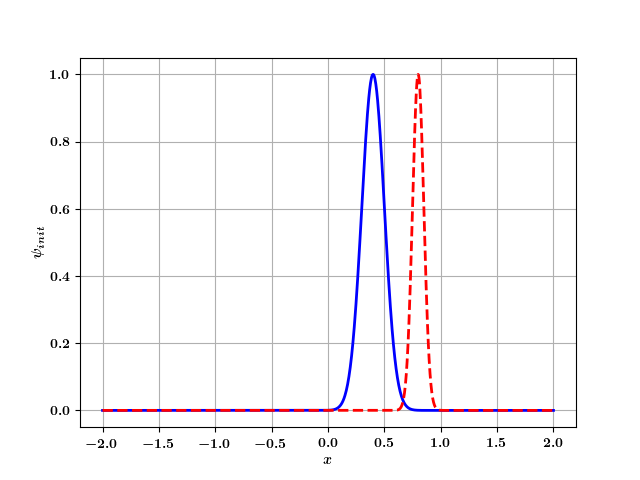

In [22]:
# ---------------------------------------------------------------------------------------------------
# --- Print psi(x) at different t ---
# ---------------------------------------------------------------------------------------------------
id_t = 0

plt.close()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(kvn.x_, kvn.get_psi_x(id_t), color='b', linewidth = 2, linestyle='-')
ax.plot(kvn.y_, kvn.get_psi_y(id_t), color='r', linewidth = 2, linestyle='--')
plt.xlabel('$x$')
plt.ylabel("$\psi_{init}$")
# ax.legend()
plt.grid(True)
plt.show()

del id_t, fig, ax

In [ ]:
# ---------------------------------------------------------------------------------------------------
# --- Print psi(x) at different t ---
# ---------------------------------------------------------------------------------------------------